## Developing a KAN

This is an adaptation of the tutorial at the following repo for my own understanding \
https://github.com/pg2455/KAN-Tutorial/blob/main/2_stacked_splines.ipynb

**AUTHOR'S NOTE:** See previous notebook for implementation of functions imported from utils

First off, we need to import a couple of things

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions

### Mathematical Theory of KANs

The Kolmogorov-Arnold Network (KAN) is a neural network architecture that uses linear combinations of splines to approximate complex functions that can model real-world data. It is based on the Kolmogorov-Arnold Representation Theorem, which states that there is only one multivariate function, which is $f(x,y,...,n) = x + y +\ ...\ + n$, a.k.a the linear combination. This is to say that all multivariate functions are a linear combination of univariate functions. A KAN uses this principle to model trends in datasets by feeding each dimension of the dataset into an activation function which is a B-spline. The B-splines in this first layer are then linearly combined and fed into another layer of B-spline activations, and so forth through the length of the network. In this way, complex multi-dimensional data can be interpreted by KANs for various purposes.

The networks are trained via a process known as backpropagation, also present in the more popular Multi-Layered Perceptron (MLP) neural network architecture. Say there is a network with a single input dimension and two layers of activation functions. 

<div>
    <center><img src="./111_KAN.png" height="75", width="75"/></center>
</div>

The operations for backpropagation are:

- $x'$ is calculated as $x' = \sum_{i=1}^{n} c_{0i} \cdot N_{0i}(x)$
- $\hat{y}$ is calculated as $\hat{y} = \sum_{i=1}^{n} c_{1i} \cdot N_{1i}(x') $
- The loss function, $\mathcal{L}$, is $\mathcal{L} = \|\hat{y} - y\|_2$.
- The gradient of $\mathcal{L}$ with respect to the coefficients $c_{1i}$ is: $\frac{\partial \mathcal{L}}{\partial c_{1i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial c_{1i}}$
- For the coefficients $c_{0i}$, the gradient is: $\frac{\partial \mathcal{L}}{\partial c_{0i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial x'} \times \frac{\partial x'}{\partial c_{0i}}$ where $\frac{\partial \hat{y}}{\partial x'} = \sum_{i=1}^{n} c_{1i} \cdot \frac{\partial N_{1i}(x')}{\partial x'}$

Where:

- $x'$ is the output of the first B-spline from the bottom
- $\hat{y}$ is output of the second B-spline, and the network's prediction
- $c_{ki}$ is the set of coefficients attached to the basis functions to make the network's features approximate the function being modeled
- $N_{ki}$ is the set of basis functions that produce the prediction curve when linearly combined
- $y$ is the set of actual datapoints in the function being modeled, as opposed to the prediction

The gradients are determined via the chain rule of calculus, with the first-layer derivatives being longer chains because they are more distant from the loss function, which is what the derivative is being taken of. The derivative of the basis function, $\frac{\partial N_{1i}(x')}{\partial x'}$ can be computed using a function in pytorch called autograd, which automatically calculates gradients.

### Program Representations

Here is a programmatic example of a [1,1,1] KAN, that is a KAN with two activation functions and a single input dimension. It will be used to model two different functions.

In [3]:
def single_stacked_kan_training(x_training, y_training, x_test, y_test, model_params=None,lr=0.1, k=2, n_layers=2, grid_sizes=[], grid_ranges= [], early_stopping_imrpovement_threshold=200, early_stopping_iterations=1e4, verbose=False, grid_range=[-1, 1], use_scales=False):
    """
    Trains a KAN of shape [1, 1, 1, ...1] with `n_layers` layers. 
    Args:
        x_training: Training inputs; number of samples x number of input dimensions
        y_training: Training targets; number of samples x 1
        x_test: Test inputs; number of samples x number of input dimensions
        y_test: Test targets; number of samples x 1
        model_params: Parameters of the model. Used in the Part 3 of the tutorial to continue training from an existing set of parameters. 
        lr: learning rate
        k: spline-order
        n_layers: number of layers in the KAN
        grid_sizes: Number of control points for each spline in the stack 
        grid_ranges: Grid ranges for each spline in the stack
        early_stopping_improvement_threshold: Number of iterations after which we can stop if there is no improvement in the validation loss
        early_stopping_iterations: Maximum number of iterations
        verbose: Whether to print the intermediate losses or not
        grid_range: Range of grids 
        use_scales: Whether to use the scaling parameters (see section 2. )
        
    """ 
    #Set default values for important variables if not given
    if grid_sizes == []:
        grid_sizes = [10] * n_layers

    if grid_ranges == []:
        grid_ranges = [[-1, 1]]* n_layers

    if not model_params:
        grids, coeffs, scale_bases, scale_splines, base_fns = [], [], [], [], []
        for idx in range(n_layers):
            grid = torch.linspace(grid_ranges[idx][0], grid_ranges[idx][1], steps=grid_sizes[idx]).unsqueeze(dim=0)
            grids.append(grid)
            
            coeff = torch.zeros((1, grid_sizes[idx] + k - 1, 1), requires_grad=True)
            coeffs.append(coeff)
    
            if use_scales:
                base_fn = torch.nn.SiLU()
                scale_base = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)
                scale_spline = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)
    
                scale_bases.append(scale_base)
                scale_splines.append(scale_spline)
                base_fns.append(base_fn)
    else:
        grids = model_params['grids']
        coeffs = model_params['coeffs']
        scale_bases = model_params['scale_bases']
        scale_splines = model_params['scale_splines']
        base_fns = model_params['base_fns']
    
    #Initialize internal variables
    losses = {'train': [], 'val': []}
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    all_xs = []

    while True:    
        x = x_training
        xs = []
        #Evalulate basis functions (fit coefficients to modeled function) for all layers
        for idx in range(n_layers):
            bases = eval_basis_functions(x, grids[idx], k)
            x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
            if use_scales:
                #Transform x using bias function (base_fns) and multiply it and the learned spline
                #with the weight parameters (scale bases, scale splines)
                base_transformed_x = base_fns[idx](x) # transformation of the original x
                x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
            else:
                x = x_

            xs.append(x.detach())

        all_xs.append(xs)

        #Compute loss function based on prediction
        y_pred = x
        loss = torch.mean(torch.pow(y_pred - y_training, 2))
        loss.backward()
        losses['train'].append(loss.item())

        # Gradient descent step (autograd has tracked the loss function via x and added it 
        # to the gradient of coeffs so that we don't need to deal with it directly here)
        for params in coeffs + scale_bases + scale_splines:
            params.data = params.data - lr * params.grad
            params.grad.zero_()

        # evaluate validation loss
        with torch.no_grad():
            x = x_test
            for idx in range(n_layers):
                bases = eval_basis_functions(x, grids[idx], k)
                x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
                if use_scales:
                    base_transformed_x = base_fns[idx](x) # transformation of the original x
                    x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
                else:
                    x = x_
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))
            
            losses['val'].append(val_loss.item())

        if i% 100 == 0 and verbose:
            print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}")
            
        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = (coeffs, base_fns, scale_bases, scale_splines)
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_imrpovement_threshold:
                print('Stopping: No further improvements...')
                break
    
        i += 1
        if i > early_stopping_iterations:
            print('Stopping: Iteration limit reached...')
            break       

    model_params = {
        'grids': grids,
        'coeffs': best_model[0],
        'scale_bases':  best_model[2],
        'scale_splines':  best_model[3],
        'base_fns': best_model[1],
    }
    return model_params, y_pred_test, losses, all_xs

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Colin\AppData\Local\Temp\ipykernel_27464\1228836383.py:2: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi* torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]
C:\Users\Colin\AppData\Local\Temp\ipykernel_27464\1228836383.py:3: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]


$f(x) = sin(\pi*e^{x})$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  453
Stopping: No further improvements...
$f(x) = sin(\pi*e^{x})$	Avg. loss:  0.01234
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  455
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.08536


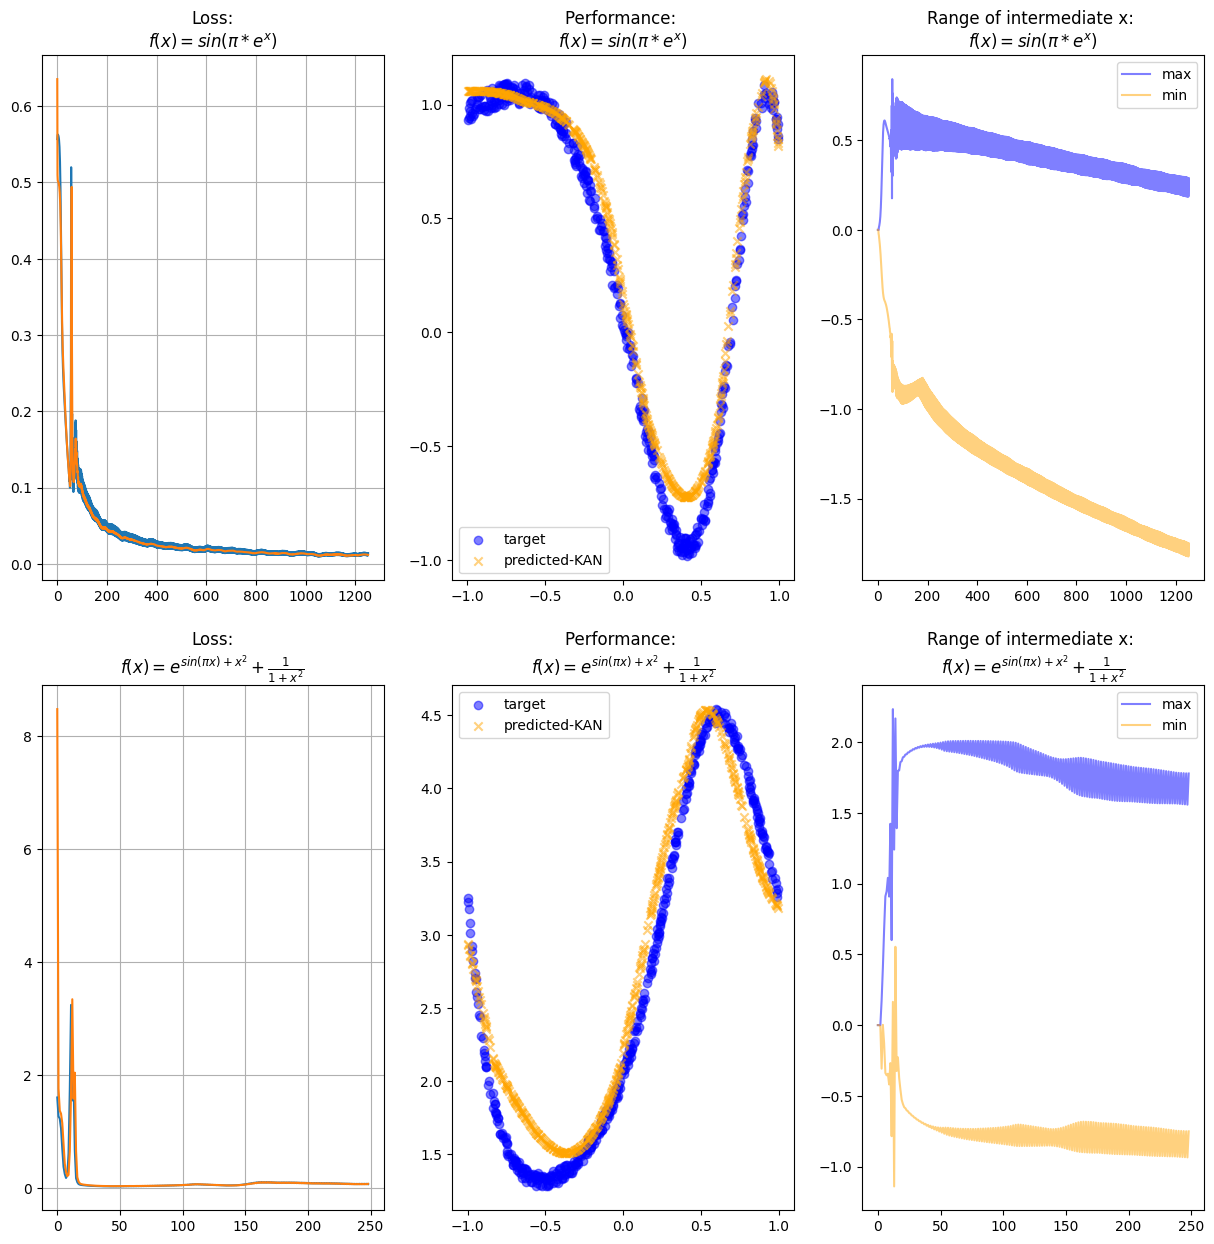

In [4]:
fns = []
fns += [(lambda x: torch.sin(torch.pi* torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]
fns += [(lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [3, 3]
grid_range = [-1, 1]

fig, axs = plt.subplots(nrows=len(fns), ncols=3, figsize=(15, 15), dpi=100)
for idx, (fn, fn_label) in enumerate(fns):
    x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
    y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    print(fn_label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))


    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=grid_range)
    print(f"{fn_label}\tAvg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')
    ax.plot(losses_kan['train'], label='train')
    ax.grid()
    ax.set_title(f"Loss:\n{fn_label}")

    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
    ax.legend()
    ax.set_title(f"Performance: \n{fn_label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color='blue', alpha=0.5, label='max')
    ax.plot(x_min, color='orange', alpha=0.5, label='min')
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{fn_label}")

The predictions are good, but not as good as they could be. There are two techniques that can be used to improve their accuracy. The first is extending the range of the grid. This is not the same as on-the-fly grid extension from the previous notebook, but extends the grid's base range in the hopes that the representative power is increased. The second technique is the implementation of learnable scaling parameters, implemented with the following formula:

$$\phi(x) = w \cdot (b(x) + \sum_{i=0}^{n}c_i \cdot N_{i}(x))$$

These two parameters, the bias function $b(x)$ and the weight factor $w$ are learned alongside the coefficients and increase the flexibility of each activation function. A comparison of each technique is shown:

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Colin\AppData\Local\Temp\ipykernel_27464\3968830993.py:1: SyntaxWarning: invalid escape sequence '\p'
  fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')


Scales: False, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  448
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.01038
Scales: False, Range:[-2, 2]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  448
Stopping: Iteration limit reached...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.00457
Scales: True, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  448
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.01106


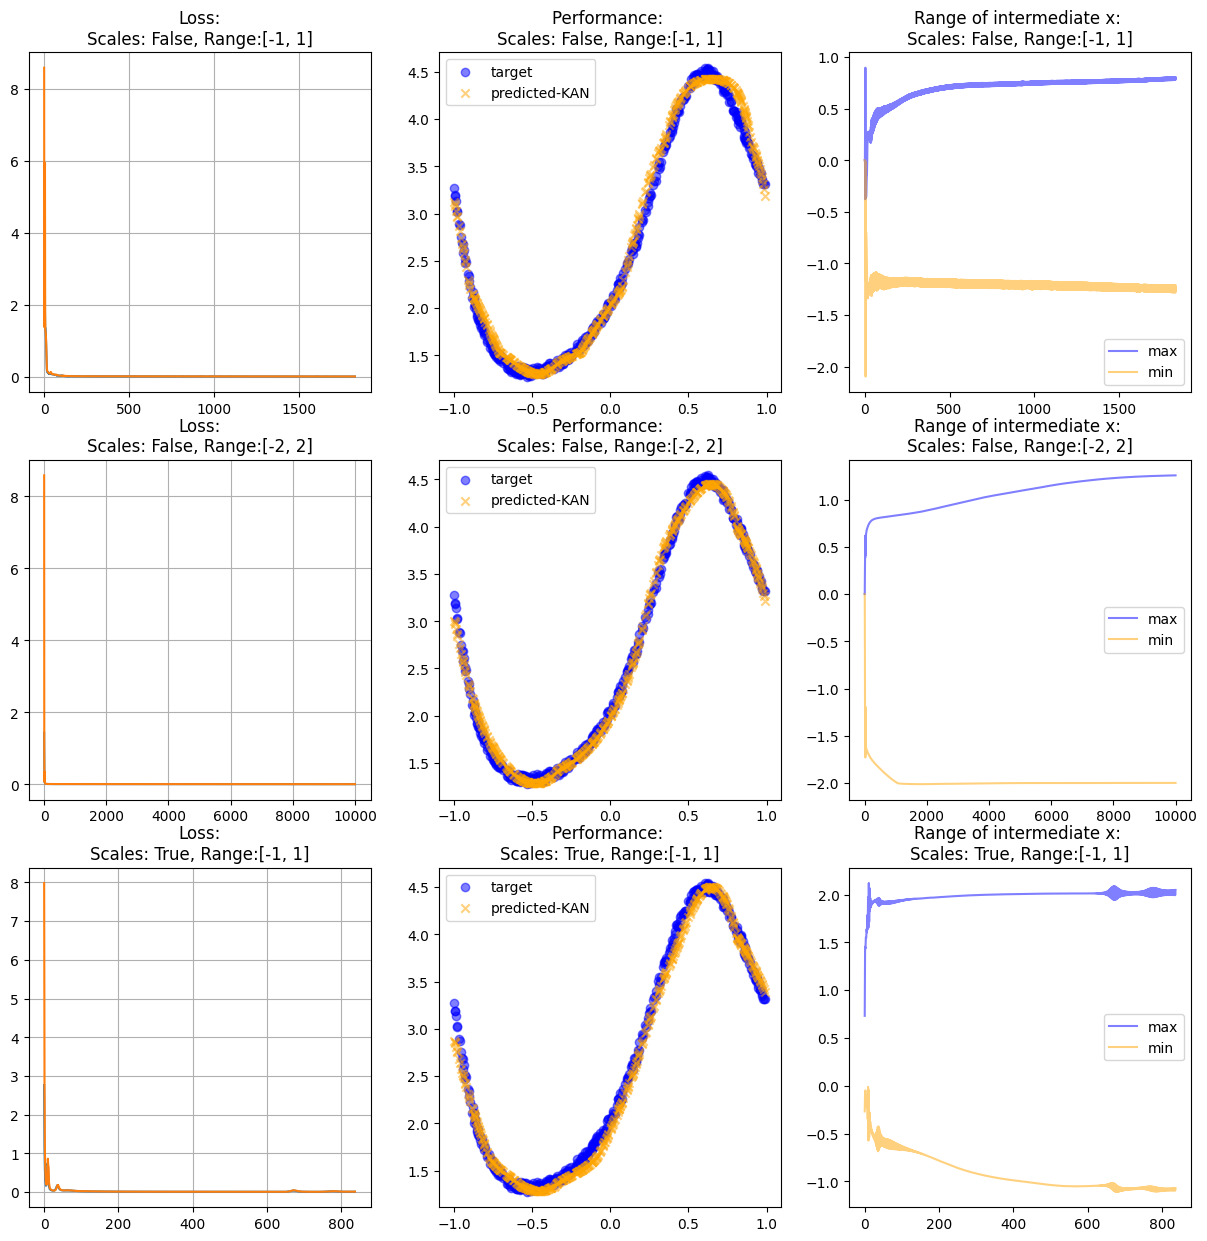

In [5]:
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')
use_scales = [True, False]


x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

params = [
    (dict(use_scales=False, grid_ranges=[[-1,1], [-1, 1]]), 'Scales: False, Range:[-1, 1]'),
    (dict(use_scales=False, grid_ranges=[[-1,1], [-2, 2]]), 'Scales: False, Range:[-2, 2]'),
    (dict(use_scales=True, grid_ranges=[[-1,1], [-1, 1]]), 'Scales: True, Range:[-1, 1]'),
]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [4, 4]

fig, axs = plt.subplots(nrows=len(params), ncols=3, figsize=(15, 15), dpi=100)
final_losses = []
for idx, param in enumerate(params):
    label = param[1]
    print(label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))


    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             **param[0])
    print(f"{fn_label}\tAvg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    final_losses.append((label, np.mean(losses_kan['val'][-100:])))

    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')
    ax.plot(losses_kan['train'], label='train')
    ax.grid()
    ax.set_title(f"Loss:\n{label}")

    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
    ax.legend()
    ax.set_title(f"Performance: \n{label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color='blue', alpha=0.5, label='max')
    ax.plot(x_min, color='orange', alpha=0.5, label='min')
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{label}")

As you can see, the additional paths of adjustment have improve the accuracy of the predictor.